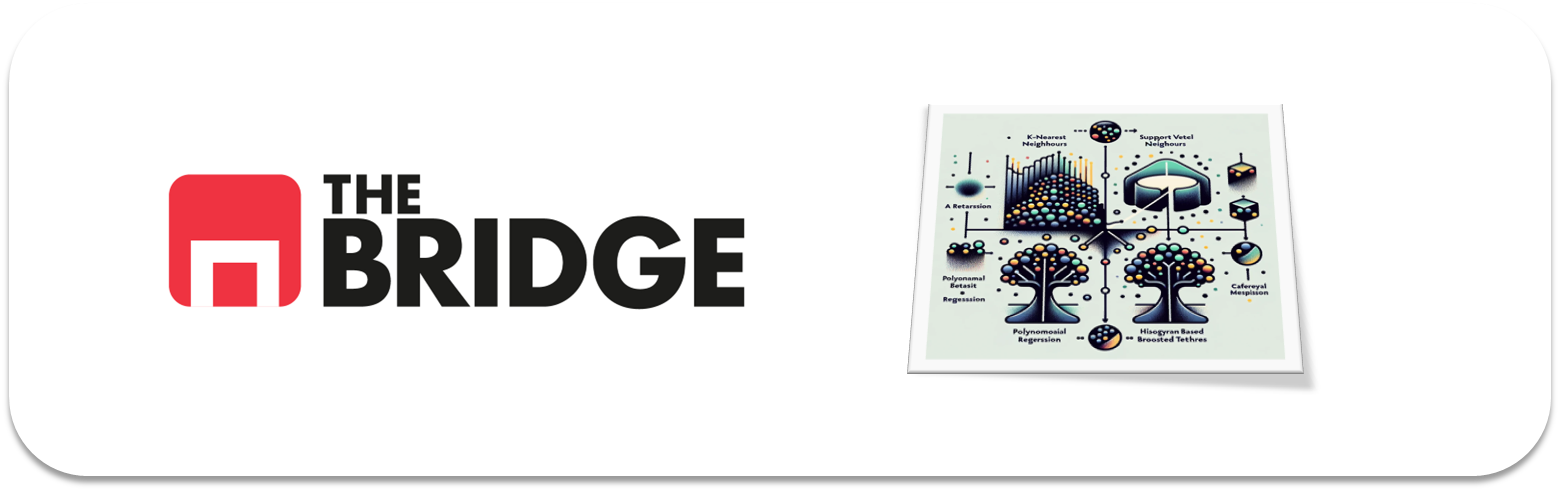

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predecir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes encontrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [2]:
# Cargamos el dataset y pegamos un vistazo a los datos

df = pd.read_csv("credit_npo.csv")
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [3]:
# Comprobamos si hay duplicados

df.duplicated(keep = False).value_counts()

False    12511
True        26
Name: count, dtype: int64

*Hay 26 duplicados. Pero OJO, no siempre los duplicados son malos, dependerá de negocio y la cantidad de variables que tengamos. Los vamos a mantener*

In [5]:
# Comprobamos la información de los datos

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

*MonthlyIncome y NumerOfDependents tienen valores nulos, por  lo que habrá que hacer algo con ellos* \
*Todas las variables son aparentemente numéricas, pero lo vamos a comprobar con la cardinalidad*

In [10]:
def card_tipo(df, umbral_categoria = 10, umbral_continua = 30):
    # Primera parte: Preparo el dataset con cardinalidades, % variación cardinalidad, y tipos
    df_temp = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.dtypes]) # Cardinaliad y porcentaje de variación de cardinalidad
    df_temp = df_temp.T # Como nos da los valores de las columnas en columnas, y quiero que estas sean filas, la traspongo
    df_temp = df_temp.rename(columns = {0: "Card", 1: "%_Card", 2: "Tipo"}) # Cambio el nombre de la transposición anterior para que tengan más sentido, y uso asignación en vez de inplace = True (esto es arbitrario para el tamaño de este dataset)

    # Corrección para cuando solo tengo un valor
    df_temp.loc[df_temp.Card == 1, "%_Card"] = 0.00

    # Creo la columna de sugerencia de tipo de variable, empiezo considerando todas categóricas pero podría haber empezado por cualquiera, siempre que adapte los filtros siguientes de forma correspondiente
    df_temp["tipo_sugerido"] = "Categorica"
    df_temp.loc[df_temp["Card"] == 2, "tipo_sugerido"] = "Binaria"
    df_temp.loc[df_temp["Card"] >= umbral_categoria, "tipo_sugerido"] = "Numerica discreta"
    df_temp.loc[df_temp["%_Card"] >= umbral_continua, "tipo_sugerido"] = "Numerica continua"

    return df_temp

In [11]:
card_tipo(df)

,Card,%_Card,Tipo,tipo_sugerido
SeriousDlqin2yrs,2,0.015953,int64,Binaria
RevolvingUtilizationOfUnsecuredLines,10764,85.857861,float64,Numerica continua
age,78,0.622158,int64,Numerica discreta
NumberOfTime30-59DaysPastDueNotWorse,10,0.079764,int64,Numerica discreta
DebtRatio,11547,92.103374,float64,Numerica continua
MonthlyIncome,4167,33.237617,float64,Numerica continua
NumberOfOpenCreditLinesAndLoans,43,0.342985,int64,Numerica discreta
NumberOfTimes90DaysLate,13,0.103693,int64,Numerica discreta
NumberRealEstateLoansOrLines,16,0.127622,int64,Numerica discreta
NumberOfTime60-89DaysPastDueNotWorse,8,0.063811,int64,Categorica


*Tras comprobarlo con la cardinalidad, tenemos "SeriousDlqin2yrs" que es binaria y "NumberOfTime60-89DaysPastDueNotWorse" que sería categórica*

In [6]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,12537.000000,12537.000000,12537.000000,12537.000000,12537.000000,11816.000000,12537.000000,12537.000000,12537.000000,12537.000000,12360.000000
mean,0.068916,0.330359,52.079445,0.409588,1.902253,6864.815420,8.482332,0.259312,0.999202,0.228364,0.822087
std,0.253321,0.368148,15.077498,4.055787,9.122216,11855.905437,5.165422,4.035658,1.134325,4.018873,1.136802
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030651,41.000000,0.000000,0.142268,3498.750000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.163490,51.000000,0.000000,0.302025,5416.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.582219,62.000000,0.000000,0.506725,8300.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,6.000000,101.000000,98.000000,99.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


*Hay variables que tienen rangos muy amplios, por lo que habrá que ver si tenemos que escalar los datos para los modelos que utilicemos*

### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

*La variable target es "SeriousDlqin2yrs". Se trata de un problema supervisado de clasificación*

### #1.3
Pinta la distribución de frecuencias del target y coméntala

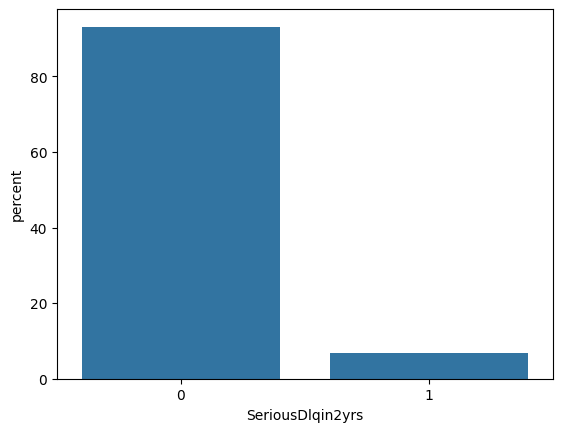

In [9]:
# Comprobamos la frecuencia de la variable target

sns.countplot(data=df, x="SeriousDlqin2yrs", stat="percent");

*Hay mucho desbalanceo en los datos: en el 85% de los casos no habrá riesgode impago en 2 años y en el 15% sí que habrá riesgo* \
*Habría que tenerlo en cuenta a la hora de hacer el split entre train y test y estratificar. Se podría hacer por ejemplo un OVERSAMPLING, UNDERSAMPLING o SMOTE* \
*Nota: Para el árbol de decisión no haría falta aplicar las técnicas de la línea superior, podemos usar el hiperparámetro "class_weight" = "balanced" para que lo trate directamente el algoritmo. El modelo de regresión logística sí que lo necesitaría pero para nuestro ejercicio no lo vamos a aplicar*

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [14]:
# Dividimos entre train y test

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
# Comprobamos la frecuencia de "SeriousDlqin2yrs" en los dataset de train y set, y así ver la estratificación

train_set["SeriousDlqin2yrs"].value_counts(normalize = True)

SeriousDlqin2yrs
0    0.930103
1    0.069897
Name: proportion, dtype: float64

*Ha quedado bastante desbalanceada la variable target en el train debido a que hay muy pocos datos de SeriousDlqin2yrs = 1* 

In [16]:
# Definimos la variable target en una variable concreta

target = "SeriousDlqin2yrs"

# Generamos las parejas X,y de train y test

X_train = train_set.drop(target, axis = 1)
y_train = train_set[target]
X_test = test_set.drop(target, axis = 1)
y_test = test_set[target]

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10029, 10)
(2508, 10)
(10029,)
(2508,)


#### HACEMOS UN MINI EDA DE LOS DATOS DE TRAIN

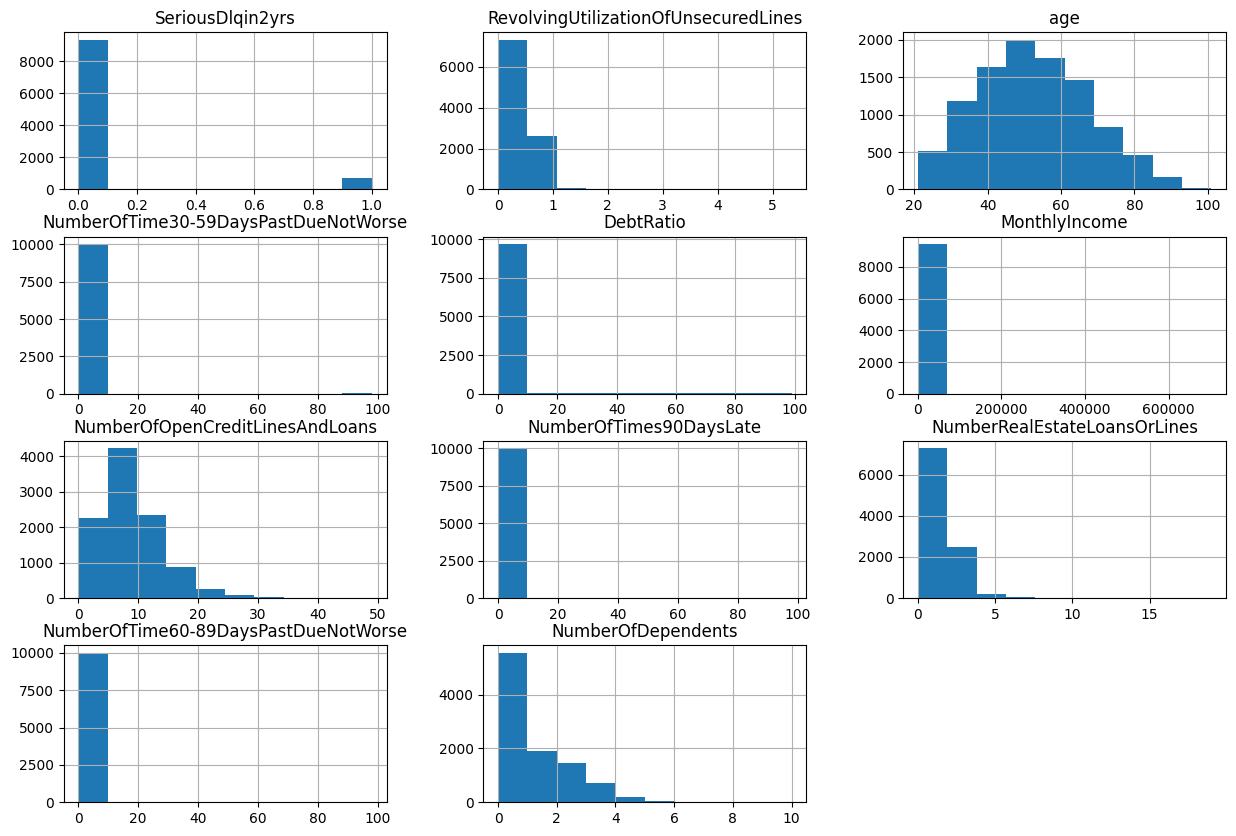

In [18]:
train_set.hist(figsize=(15, 10));

In [27]:
train_set.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [26]:
from bootcampviztools import plot_combined_graphs

In [37]:
def plot_histo_den(df, columns):
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histograma y KDE de {column}')

    # Ocultar ejes vacíos
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

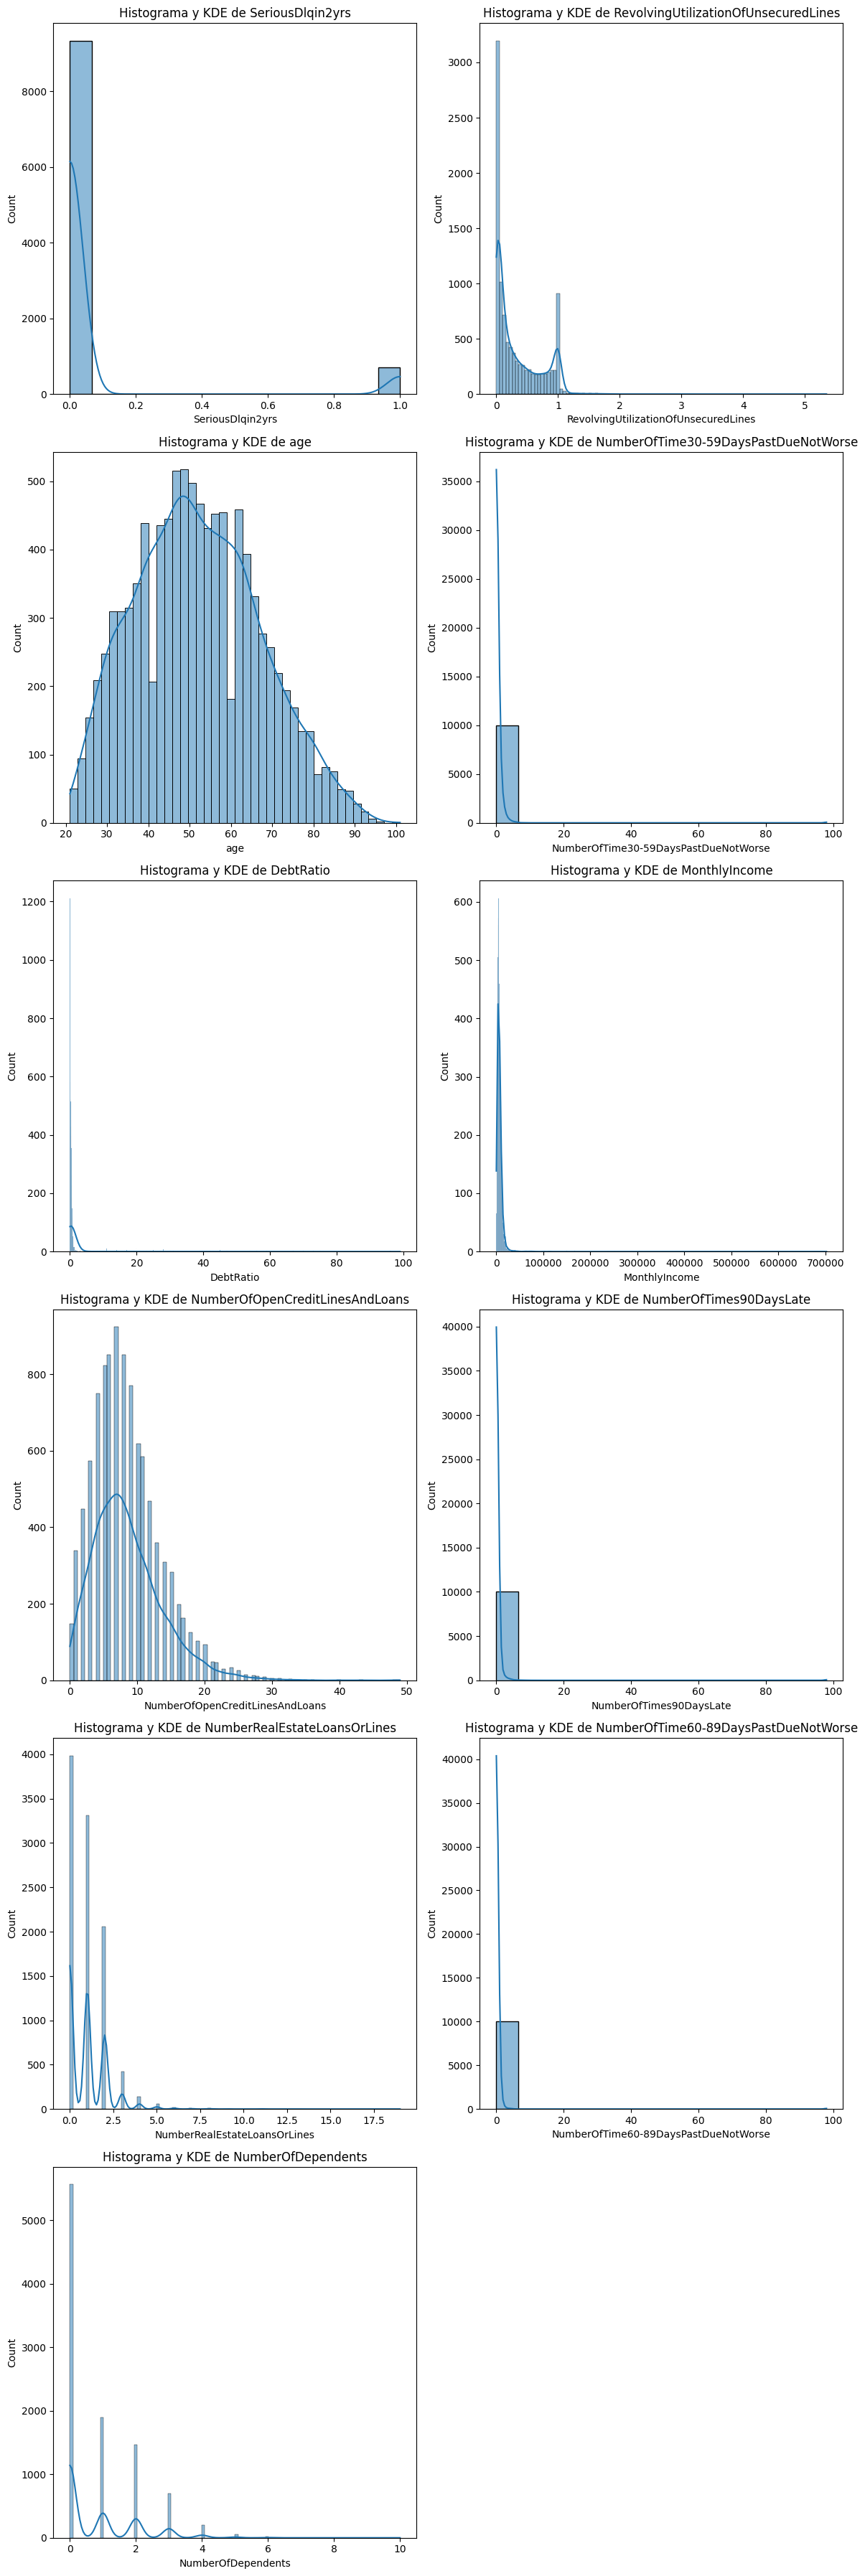

In [38]:
plot_histo_den(train_set, train_set.columns)

In [23]:
train_set["RevolvingUtilizationOfUnsecuredLines"].value_counts()

RevolvingUtilizationOfUnsecuredLines
0.000000    702
1.000000    700
0.089080      2
0.443001      2
1.086379      2
           ... 
0.367595      1
0.003000      1
0.259514      1
0.107195      1
0.025624      1
Name: count, Length: 8616, dtype: int64

In [24]:
train_set["NumberOfTimes90DaysLate"].value_counts()

NumberOfTimes90DaysLate
0     9474
1      333
2      112
3       44
4       27
98      16
5        9
6        5
8        3
7        3
9        1
13       1
10       1
Name: count, dtype: int64

Para revisar luego:

*MonthlyIncome y NumerOfDependents tienen valores nulos, por  lo que habrá que hacer algo con ellos* \

*Tras comprobarlo con la cardinalidad, tenemos "SeriousDlqin2yrs" que es binaria y "NumberOfTime60-89DaysPastDueNotWorse" que sería categórica*

*Hay variables que tienen rangos muy amplios, por lo que habrá que ver si tenemos que escalar los datos para los modelos que utilicemos*

*Hay mucho desbalanceo en los datos: en el 85% de los casos no habrá riesgode impago en 2 años y en el 15% sí que habrá riesgo* \
*Habría que tenerlo en cuenta a la hora de hacer el split entre train y test y estratificar. Se podría hacer por ejemplo un OVERSAMPLING, UNDERSAMPLING o SMOTE* \
*Nota: Para el árbol de decisión no haría falta aplicar las técnicas de la línea superior, podemos usar el hiperparámetro "class_weight" = "balanced" para que lo trate directamente el algoritmo. El modelo de regresión logística sí que lo necesitaría pero para nuestro ejercicio no lo vamos a aplicar*